In [10]:
import imageio as iio#导入关于图片的库#
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F#神经网络的函数的库#
from scipy import ndimage#图像处理的库#

In [11]:
def imread(path, is_grayscale=True):#定义读取图片函数，使用iio.imread#
    """
    Read image from the giving path.
    Default value is gray-scale, and image is read by YCbCr format as the paper.
    """
    if is_grayscale:
        return iio.imread(path, as_gray=True, pilmode='YCbCr').astype(np.float32)
    #pilmode='YCbCr'：图像格式为YCbCr，.astype(np.float32)：数据格式设为float32，节省空间#
    else:
        return iio.imread(path, pilmode='YCbCr').astype(np.float32)


In [12]:
def modcrop(image, scale=3):#图像剪裁函数，为了保证在缩放图像操作时能够整除#
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.

    We need to find modulo of height (and width) and scale factor.
    Then, subtract the modulo from height (and width) of original image size.
    There would be no remainder even after scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)#如果h除以scale（缩放倍率）不能整除，那么就用h减去mod（余数），新得到的h则可以整除#
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]#剪裁为可以整除的图片#
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [13]:
def preprocess(path, scale=3):#预处理#
    """
    Preprocess single image file
      (1) Read original image as YCbCr format (and grayscale as default)
      (2) Normalize
      (3) Apply image file with interpolation
    Args:
      path: file path of desired file
      input_: image applied interpolation (low-resolution)
      label_: image with original resolution (high-resolution), groundtruth
    """
    image = imread(path, is_grayscale=True)#读取灰度图#
    label_ = modcrop(image, scale)#剪裁#

    # Must be normalized
    label_ = label_ / 255.#正规化#

    input_ = ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)#先缩小#
    input_ = ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)#再放大#

    return input_, label_#缩小放大后的作为低清图像输入，光正规化的作为高请图像标签#

In [14]:
"""Define the model weights and biases 
"""
## ------ Add your code here: set the weight of three conv layers
# replace 'None' with your hyper parameter numbers
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5

class SRCNN(nn.Module):#定义神经网络参数#
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [15]:
"""Load the pre-trained model file
"""
model = SRCNN()#导入上面的模型#
model.load_state_dict(torch.load('./model/model.pth'))#导入提前训练好的参数#
model.eval()#如果不加eval会改变模型权值#

"""Read the test image
"""
LR_image, HR_image = preprocess('./image/butterfly_GT.bmp')#缩小放大后的作为低清图像输入，光正规化的作为高请图像标签#
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(LR_image, axis=0), axis=0)#嵌套升维函数，升维两次，由2d到4d#
input_ = torch.from_numpy(input_)#将数组转化为张量#

"""Run the model and get the SR image
"""
with torch.no_grad():#不进行计算图操作#
    output_ = model(input_)

##------ Add your code here: save the LR and SR images and compute the psnr
# hints: use the 'iio.imsave()'  and ' skimage.metrics.peak_signal_noise_ratio()'

In [16]:
iio.imsave('./image/LR_image.bmp',(LR_image*255).astype(np.uint8))#saveLR#
iio.imsave('./image/SR_image.bmp',(np.squeeze(output_.numpy())*255).astype(np.uint8))#saveSR#
iio.imsave('./image/HR_image.bmp',(HR_image*255).astype(np.uint8))#saveHR#

In [18]:
import skimage
from skimage.metrics import peak_signal_noise_ratio
skimage.metrics.peak_signal_noise_ratio((HR_image*255).astype(np.uint8),(np.squeeze(output_.numpy())*255).astype(np.uint8))#psnr of SR and HR#

22.923322214270737

In [20]:
skimage.metrics.peak_signal_noise_ratio((LR_image*255).astype(np.uint8),(HR_image*255).astype(np.uint8))#psnr of LR and HR#

20.49756351563886

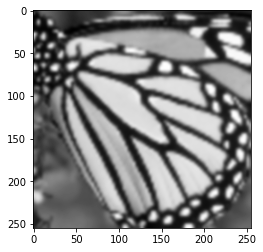

In [31]:
plt.imshow(LR_image,cmap='gray')

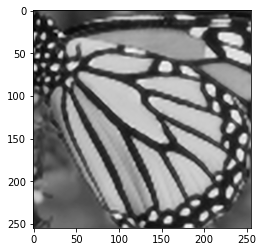

In [30]:
plt.imshow(np.squeeze(output_.numpy()),cmap='gray')

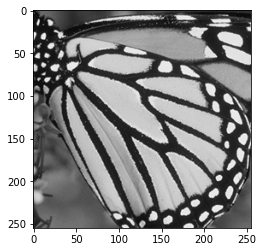

In [29]:
plt.imshow(HR_image,cmap='gray')